3/6/2021

## Load libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

from sklearn.neural_network import MLPClassifier

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Load and set data paths

In [ ]:
Ravdess = '/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/audio_speech_actors_01-24/'

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,calm,/content/drive/MyDrive/Colab Notebooks/speech/...
1,happy,/content/drive/MyDrive/Colab Notebooks/speech/...
2,sad,/content/drive/MyDrive/Colab Notebooks/speech/...
3,angry,/content/drive/MyDrive/Colab Notebooks/speech/...
4,calm,/content/drive/MyDrive/Colab Notebooks/speech/...


In [ ]:
Ravdess_df.to_csv('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/ravdess_path.csv', index=0)

In [ ]:
Ravdess_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/ravdess_path.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


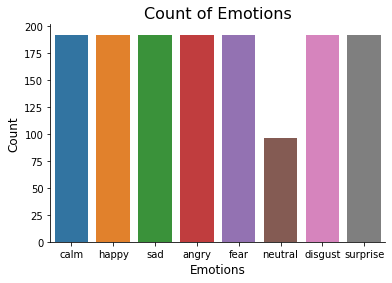

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

## Feature extraction

In [ ]:
observed_emotions=sorted(['fear', 'happy', 'sad', 'angry'])

In [ ]:
num_mfcc = 13

In [ ]:
def extract_feature(path, mfcc, chroma, mel, tempo):
  data, sample_rate = librosa.load(path, res_type='kaiser_fast')
  if chroma:
    stft = np.abs(librosa.stft(data))

  result=np.array([])
  if mfcc:
    mfccs=np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=num_mfcc).T, axis=0)
    result=np.hstack((result, mfccs))
  if chroma:
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result=np.hstack((result, chroma))
  if mel:
    mel=np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result=np.hstack((result, mel))
  if tempo:
    tempo=np.mean(librosa.feature.tempogram(y=data, sr=sample_rate).T, axis=0)
    result=np.hstack((result, tempo))

  return result

In [ ]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
  if emotion not in observed_emotions:
    continue
  feature = extract_feature(path, mfcc=False, chroma=False, mel=False, tempo=True)
  X.append(feature)
  Y.append(emotion)

In [ ]:
len(X), len(Y)

(768, 768)

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv(f'/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/tempogram_features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,labels
0,1.0,0.684434,0.381323,0.315699,0.363797,0.372512,0.303962,0.324587,0.415008,0.417524,0.374738,0.356981,0.383409,0.465840,0.440218,0.364785,0.311289,0.331993,0.378419,0.346734,0.291878,0.310292,0.375156,0.324510,0.241268,0.272568,0.409486,0.468645,0.395707,0.331869,0.317061,0.321055,0.254071,0.229254,0.264213,0.305442,0.292015,0.269244,0.289167,0.315280,...,-3.734611e-17,6.453194e-17,1.691154e-17,5.303013e-17,-2.132890e-17,2.123227e-17,1.393175e-17,2.321580e-17,6.795941e-18,9.193692e-18,-1.358994e-18,4.392269e-17,8.810624e-18,5.532524e-17,-4.857724e-18,5.683435e-17,-4.627983e-17,4.582989e-17,-3.245268e-17,1.420816e-17,6.403324e-18,2.864993e-17,1.874801e-17,-4.286480e-17,4.707281e-17,-3.910225e-17,2.761268e-17,-8.322288e-18,1.934100e-17,-4.494175e-17,7.871954e-17,-3.707398e-17,2.700953e-17,2.593287e-17,-1.582210e-17,4.275779e-17,1.325684e-18,1.507654e-17,1.507481e-17,happy
1,1.0,0.718239,0.429905,0.358201,0.391767,0.407020,0.369876,0.366181,0.379321,0.398611,0.387875,0.371602,0.402928,0.436221,0.415935,0.426465,0.381726,0.296488,0.286424,0.337119,0.371600,0.319061,0.283075,0.350011,0.440033,0.458302,0.334464,0.278501,0.287389,0.276154,0.234013,0.268102,0.315904,0.296003,0.281163,0.315682,0.338363,0.245904,0.196263,0.181075,...,-3.169278e-17,6.655589e-17,1.389399e-17,3.772211e-17,-7.566097e-18,2.632952e-17,1.290059e-17,2.385455e-17,8.670609e-18,2.285317e-17,1.200658e-18,5.294164e-17,8.510281e-18,4.050176e-17,-6.615700e-18,4.813192e-17,-4.515122e-17,4.916996e-17,-3.782390e-17,1.885078e-17,-2.347669e-18,2.622868e-17,2.529666e-17,-3.680195e-17,2.625130e-17,-4.013103e-17,2.030790e-17,-7.108426e-18,2.296843e-17,-5.197880e-17,6.043015e-17,-2.176813e-17,3.269775e-17,1.253088e-17,-6.904360e-18,4.089239e-17,-9.300289e-18,1.876983e-17,1.719912e-17,sad
2,1.0,0.738835,0.464905,0.391983,0.398921,0.420978,0.423360,0.411740,0.386683,0.372563,0.373784,0.388009,0.453791,0.566352,0.599426,0.516212,0.489704,0.484099,0.418292,0.365541,0.336817,0.339909,0.332131,0.345839,0.354029,0.352983,0.368194,0.453373,0.504917,0.486332,0.465271,0.417245,0.376992,0.356485,0.321457,0.284973,0.280165,0.316241,0.329315,0.310786,...,7.224722e-08,5.732959e-08,4.509759e-08,3.513531e-08,2.707811e-08,2.061007e-08,1.546064e-08,1.140037e-08,8.236882e-09,5.810161e-09,3.985338e-09,2.645534e-09,1.689206e-09,1.029196e-09,5.919389e-10,3.166232e-10,1.542208e-10,6.635029e-11,2.409112e-11,6.856975e-12,1.321486e-12,1.136542e-13,4.267823e-17,-4.537954e-17,5.595816e-17,-5.368287e-17,3.464886e-17,-1.642577e-17,3.495048e-17,-4.935990e-17,8.943410e-17,-3.226123e-17,4.087913e-17,2.567693e-17,1.564107e-19,5.019410e-17,1.219639e-18,2.315104e-17,2.976570e-17,angry
3,1.0,0.635103,0.406910,0.411493,0.410887,0.342485,0.329236,0.334363,0.370555,0.395563,0.365006,0.341023,0.374024,0.391686,0.381611,0.387885,0.299547,0.259754,0.281750,0.318435,0.316720,0.314392,0.315817,0.352933,0.405055,0.357852,0.330598,0.332980,0.302318,0.238902,0.226986,0.271831,0.345633,0.374756,0.365644,0.313160,0.272774,0.244237,0.207134,0.194055,...,-3.874506e-17,5.719856e-17,1.205596e-17,3.770496e-17,-1.756659e-17,1.907718e-17,7.882742e-18,1.586450e-17,6.692206e-18,1.680508e-17,-2.401926e-18,5.503119e-17,1.237641e-17,3.657600e-17,-1.293922e-17,4.330203e-17,-4.051145e-17,4.459077e-17,-3.339201e-17,1.343793e-17,1.581917e-18,1.405179e-17,1.757829e-17,-3.549109e-17,3.394709e-17,-4.093304e-17,1.092685e-17,-2.281932e-18,1.480616e-17,-5.016810e-17,6.776955e-17,-2.791640e-17,3.576502e-17,7.930375e-18,-1.094875e-17,4.298573e-17,-4.057661e-18,1.269712e-17,1.147035e-17,fear
4,1.0,0.658047,0.365066,0.289179,0.298486,0.305922,0.316937,0.357566,0.437484,0.460775,0.376933,0.331721,0.364036,0.383774,0.385387,0.381307,0.353505,0.324381,0.335999,0.321367,0.250754,

In [ ]:
Features.shape

(768, 385)

In [ ]:
Features[0].value_counts()

1.0    768
Name: 0, dtype: int64

## Data Preparation

In [ ]:
dataset = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/tempogram_features.csv')
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,labels
0,1.0,0.684434,0.381323,0.315699,0.363797,0.372512,0.303962,0.324587,0.415008,0.417524,0.374738,0.356981,0.383409,0.465840,0.440218,0.364785,0.311289,0.331993,0.378419,0.346734,0.291878,0.310292,0.375156,0.324510,0.241268,0.272568,0.409486,0.468645,0.395707,0.331869,0.317061,0.321055,0.254071,0.229254,0.264213,0.305442,0.292015,0.269244,0.289167,0.315280,...,-3.734611e-17,6.453194e-17,1.691154e-17,5.303013e-17,-2.132890e-17,2.123227e-17,1.393175e-17,2.321580e-17,6.795941e-18,9.193692e-18,-1.358994e-18,4.392269e-17,8.810624e-18,5.532524e-17,-4.857724e-18,5.683435e-17,-4.627983e-17,4.582989e-17,-3.245268e-17,1.420816e-17,6.403324e-18,2.864993e-17,1.874801e-17,-4.286480e-17,4.707281e-17,-3.910225e-17,2.761268e-17,-8.322288e-18,1.934100e-17,-4.494175e-17,7.871954e-17,-3.707398e-17,2.700953e-17,2.593287e-17,-1.582210e-17,4.275779e-17,1.325684e-18,1.507654e-17,1.507481e-17,happy
1,1.0,0.718239,0.429905,0.358201,0.391767,0.407020,0.369876,0.366181,0.379321,0.398611,0.387875,0.371602,0.402928,0.436221,0.415935,0.426465,0.381726,0.296488,0.286424,0.337119,0.371600,0.319061,0.283075,0.350011,0.440033,0.458302,0.334464,0.278501,0.287389,0.276154,0.234013,0.268102,0.315904,0.296003,0.281163,0.315682,0.338363,0.245904,0.196263,0.181075,...,-3.169278e-17,6.655589e-17,1.389399e-17,3.772211e-17,-7.566097e-18,2.632952e-17,1.290059e-17,2.385455e-17,8.670609e-18,2.285317e-17,1.200658e-18,5.294164e-17,8.510281e-18,4.050176e-17,-6.615700e-18,4.813192e-17,-4.515122e-17,4.916996e-17,-3.782390e-17,1.885078e-17,-2.347669e-18,2.622868e-17,2.529666e-17,-3.680195e-17,2.625130e-17,-4.013103e-17,2.030790e-17,-7.108426e-18,2.296843e-17,-5.197880e-17,6.043015e-17,-2.176813e-17,3.269775e-17,1.253088e-17,-6.904360e-18,4.089239e-17,-9.300289e-18,1.876983e-17,1.719912e-17,sad
2,1.0,0.738835,0.464905,0.391983,0.398921,0.420978,0.423360,0.411740,0.386683,0.372563,0.373784,0.388009,0.453791,0.566352,0.599426,0.516212,0.489704,0.484099,0.418292,0.365541,0.336817,0.339909,0.332131,0.345839,0.354029,0.352983,0.368194,0.453373,0.504917,0.486332,0.465271,0.417245,0.376992,0.356485,0.321457,0.284973,0.280165,0.316241,0.329315,0.310786,...,7.224722e-08,5.732959e-08,4.509759e-08,3.513531e-08,2.707811e-08,2.061007e-08,1.546064e-08,1.140037e-08,8.236882e-09,5.810161e-09,3.985338e-09,2.645534e-09,1.689206e-09,1.029196e-09,5.919389e-10,3.166232e-10,1.542208e-10,6.635029e-11,2.409112e-11,6.856975e-12,1.321486e-12,1.136542e-13,4.267823e-17,-4.537954e-17,5.595816e-17,-5.368287e-17,3.464886e-17,-1.642577e-17,3.495048e-17,-4.935990e-17,8.943410e-17,-3.226123e-17,4.087913e-17,2.567693e-17,1.564107e-19,5.019410e-17,1.219639e-18,2.315104e-17,2.976570e-17,angry
3,1.0,0.635103,0.406910,0.411493,0.410887,0.342485,0.329236,0.334363,0.370555,0.395563,0.365006,0.341023,0.374024,0.391686,0.381611,0.387885,0.299547,0.259754,0.281750,0.318435,0.316720,0.314392,0.315817,0.352933,0.405055,0.357852,0.330598,0.332980,0.302318,0.238902,0.226986,0.271831,0.345633,0.374756,0.365644,0.313160,0.272774,0.244237,0.207134,0.194055,...,-3.874506e-17,5.719856e-17,1.205596e-17,3.770496e-17,-1.756659e-17,1.907718e-17,7.882742e-18,1.586450e-17,6.692206e-18,1.680508e-17,-2.401926e-18,5.503119e-17,1.237641e-17,3.657600e-17,-1.293922e-17,4.330203e-17,-4.051145e-17,4.459077e-17,-3.339201e-17,1.343793e-17,1.581917e-18,1.405179e-17,1.757829e-17,-3.549109e-17,3.394709e-17,-4.093304e-17,1.092685e-17,-2.281932e-18,1.480616e-17,-5.016810e-17,6.776955e-17,-2.791640e-17,3.576502e-17,7.930375e-18,-1.094875e-17,4.298573e-17,-4.057661e-18,1.269712e-17,1.147035e-17,fear
4,1.0,0.658047,0.365066,0.289179,0.298486,0.305922,0.316937,0.357566,0.437484,0.460775,0.376933,0.331721,0.364036,0.383774,0.385387,0.381307,0.353505,0.324381,0.335999,0.321367,0.250754,

In [ ]:
dataset.labels.value_counts()

happy    192
sad      192
angry    192
fear     192
Name: labels, dtype: int64

## Modeling

### MLPClassifier

In [ ]:
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size = 0.25, random_state = 9)

In [ ]:
x_train.shape

(576, 384)

In [ ]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=1000)

In [ ]:
model.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### Light GBM

In [ ]:
data = dataset.copy()
data.labels = data.labels.map({'angry':0, 'fear':1, 'happy':2, 'sad':3})

In [ ]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values

In [ ]:
data.labels.value_counts()

3    192
2    192
1    192
0    192
Name: labels, dtype: int64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_valid = sc.transform(x_valid)

In [ ]:
NUM_CLASS = 4

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['num_leaves'] = 100
params['min_data'] = 100
params['max_depth'] = 50
params['num_class'] = NUM_CLASS
params['max_bin'] = 150 # small max_bin causes faster speed and large value improves accuracy
params['bagging_freq'] = 100
params['feature_fraction'] = 0.6 # deal with column
params['bagging_fraction'] = 0.6
# params['device'] = 'gpu'
#params['num_iterations'] = 1000
#params['early_stopping_rounds'] = 100# the rule of thumb is to have it at 10% of your num_iterations

In [ ]:
x_test.shape

(192, 383)

In [ ]:
import lightgbm as lgb

In [ ]:
dtrain = lgb.Dataset(x_train, y_train)
dvalid = lgb.Dataset(x_valid, y_valid)
lgb_model = lgb.train(params, 
                          dtrain, 
                          num_boost_round=10000,
                          early_stopping_rounds=1000,
                          valid_sets=(dtrain, dvalid), 
                          valid_names=('train','valid'),
                          verbose_eval = 100)

Training until validation scores don't improve for 1000 rounds.
[100]	train's multi_logloss: 1.28908	valid's multi_logloss: 1.36674
[200]	train's multi_logloss: 1.22297	valid's multi_logloss: 1.37228
[300]	train's multi_logloss: 1.17973	valid's multi_logloss: 1.35945
[400]	train's multi_logloss: 1.14852	valid's multi_logloss: 1.3698
[500]	train's multi_logloss: 1.11468	valid's multi_logloss: 1.37346
[600]	train's multi_logloss: 1.09181	valid's multi_logloss: 1.36995
[700]	train's multi_logloss: 1.06488	valid's multi_logloss: 1.37326
[800]	train's multi_logloss: 1.04231	valid's multi_logloss: 1.36492
[900]	train's multi_logloss: 1.02157	valid's multi_logloss: 1.35793
[1000]	train's multi_logloss: 1.00063	valid's multi_logloss: 1.38528
[1100]	train's multi_logloss: 0.987659	valid's multi_logloss: 1.4064
[1200]	train's multi_logloss: 0.966254	valid's multi_logloss: 1.39747
[1300]	train's multi_logloss: 0.946218	valid's multi_logloss: 1.39684
[1400]	train's multi_logloss: 0.925813	valid's 

## Experiment result

### MLP

In [ ]:
preds = loaded_model.predict(x_test)

In [ ]:
results = pd.DataFrame()
results['Actual'] = y_test
results['Predicted'] = preds

results.head()

,Actual,Predicted
0,sad,sad
1,sad,angry
2,angry,angry
3,happy,angry
4,fear,sad


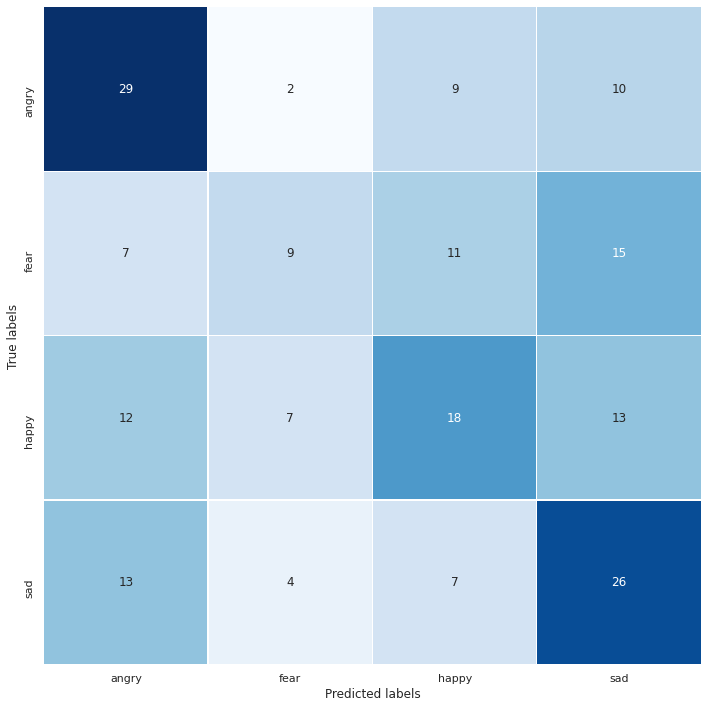

In [ ]:
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm,
                     index=observed_emotions,
                     columns=observed_emotions)
plt.figure(figsize=(10, 10))

sns.set(font_scale=1)


ax = sns.heatmap(df_cm, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.tight_layout()

name = 'tempogram feature 43%.png'
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Confusion matrix/mlp Confusion matrix for ' + name)

plt.show()

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       angry       0.48      0.58      0.52        50
        fear       0.41      0.21      0.28        42
       happy       0.40      0.36      0.38        50
         sad       0.41      0.52      0.46        50

    accuracy                           0.43       192
   macro avg       0.42      0.42      0.41       192
weighted avg       0.42      0.43      0.42       192



In [ ]:
import pickle

filename = 'tempogram_MLP_0.43.sav'
# pickle.dump(model, open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Models/' + filename, 'wb'))
loaded_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Models/' + filename, 'rb'))

### Light GBM

In [ ]:
preds = lgb_model.predict(x_test)

In [ ]:
predictions = []

for x in preds:
    predictions.append(np.argmax(x))

In [ ]:
results = pd.DataFrame()
results['Actual'] = y_test
results['Predicted'] = predictions

results['Actual'] = results['Actual'].map({0:'angry', 1:'fear', 2:'happy', 3:'sad'})
results['Predicted'] = results['Predicted'].map({0:'angry', 1:'fear', 2:'happy', 3:'sad'})
results.head()

,Actual,Predicted
0,fear,sad
1,fear,angry
2,fear,fear
3,angry,fear
4,sad,happy


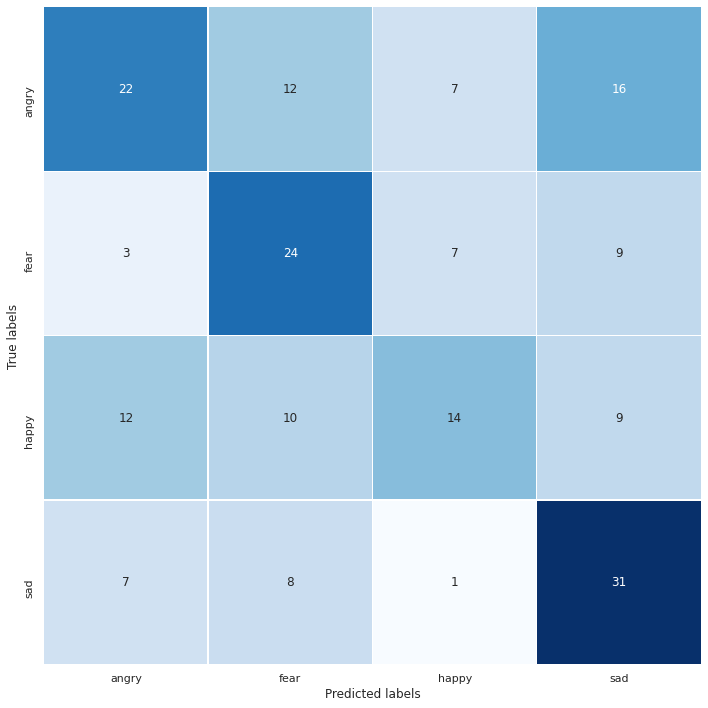

In [ ]:
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm,
                     index=observed_emotions,
                     columns=observed_emotions)

plt.figure(figsize=(10, 10))

sns.set(font_scale=1)

ax = sns.heatmap(df_cm, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.tight_layout()

name = 'tempogram feature 47%.png'
plt.savefig('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Confusion matrix/lgbm Confusion matrix for ' + name)

plt.show()

In [ ]:
print(classification_report(y_test, predictions, target_names=observed_emotions))

              precision    recall  f1-score   support

       angry       0.50      0.39      0.44        57
        fear       0.44      0.56      0.49        43
       happy       0.48      0.31      0.38        45
         sad       0.48      0.66      0.55        47

    accuracy                           0.47       192
   macro avg       0.48      0.48      0.47       192
weighted avg       0.48      0.47      0.46       192



In [ ]:
import pickle

filename = 'tempogram_GBM_0.47.sav'
pickle.dump(lgb_model, open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Models/' + filename, 'wb'))
loaded_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Models/' + filename, 'rb'))